# Цель лабораторной работы
Изучить сложные способы подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей<cite data-cite="ue:lab4"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab4"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите модель ближайших соседей для&nbsp;произвольно заданного гиперпараметра $K$. Оцените качество модели с&nbsp;помощью трех подходящих для&nbsp;задачи метрик.
5. Постройте модель и оцените качество модели с&nbsp;использованием кросс-валидации. Проведите эксперименты с&nbsp;тремя различными стратегиями кросс-валидации.
6. Произведите подбор гиперпараметра $K$ с&nbsp;использованием `GridSearchCV` и кросс-валидации.
7. Повторите пункт&nbsp;4 для&nbsp;найденного оптимального значения гиперпараметра $K$. Сравните качество полученной модели с&nbsp;качеством модели, полученной в&nbsp;пункте&nbsp;4.
8. Постройте кривые обучения и валидации.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [0]:
from google.colab import files
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в&nbsp;дальнейшем текст в&nbsp;отчёте влезал на&nbsp;А4<cite data-cite="doc:pandas"></cite>:

In [0]:
pd.set_option("display.width", 70)

## Предварительная подготовка данных

В&nbsp;качестве набора данных используем датасет со статистикой игр в TFT

In [68]:
uploaded = files.upload()

Saving TFT_Platinum_MatchData.csv to TFT_Platinum_MatchData.csv


In [0]:
data = pd.read_csv("TFT_Platinum_MatchData.csv")

Проверим полученные типы:

In [70]:
data.dtypes

gameId             object
gameDuration      float64
level               int64
lastRound           int64
Ranked              int64
ingameDuration    float64
combination        object
champion           object
dtype: object

Посмотрим на данные в&nbsp;данном наборе данных:

In [84]:
data.head()

,gameDuration,level,lastRound,Ranked,ingameDuration
0,1963.905273,6,27,5,1390.165771
1,1963.905273,8,37,3,1891.282715
2,1963.905273,6,25,7,1279.461060
3,1963.905273,7,38,2,1955.608521
4,1963.905273,8,38,1,1955.608521


Избавимся от не числовых данных

In [0]:
data.drop(['gameId', 'combination', 'champion'],axis='columns', inplace=True)

Проверим размер набора данных:

In [85]:
data.shape

(80000, 5)

Проверим основные статистические характеристики набора данных:

In [86]:
data.describe()

,gameDuration,level,lastRound,Ranked,ingameDuration
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,2168.427079,7.785637,33.193112,4.496375,1881.922944
std,156.294695,0.828188,4.878634,2.294254,279.213257
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2073.243225,7.000000,30.000000,2.000000,1705.082611
50%,2164.299072,8.000000,34.000000,4.000000,1903.187744
75%,2261.792358,8.000000,37.000000,6.000000,2076.401306
max,2714.283691,9.000000,48.000000,8.000000,2706.018555


Проверим наличие пропусков в&nbsp;данных:

In [87]:
data.isnull().sum()

gameDuration      0
level             0
lastRound         0
Ranked            0
ingameDuration    0
dtype: int64

## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [0]:
y = data["level"]
X = data.drop("level", axis=1)

In [89]:
print(X.head(), "\n")
print(y.head())

   gameDuration  lastRound  Ranked  ingameDuration
0   1963.905273         27       5     1390.165771
1   1963.905273         37       3     1891.282715
2   1963.905273         25       7     1279.461060
3   1963.905273         38       2     1955.608521
4   1963.905273         38       1     1955.608521 

0    6
1    8
2    6
3    7
4    8
Name: level, dtype: int64


In [90]:
print(X.shape)
print(y.shape)

(80000, 4)
(80000,)


Предобработаем данные, чтобы методы работали лучше:

In [91]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,gameDuration,lastRound,Ranked,ingameDuration
count,8.000000e+04,8.000000e+04,8.000000e+04,8.000000e+04
mean,-8.050338e-16,-1.837815e-16,1.831951e-16,-1.173825e-16
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-1.387405e+01,-6.803815e+00,-1.959854e+00,-6.740134e+00
25%,-6.090063e-01,-6.545137e-01,-1.088105e+00,-6.333562e-01
50%,-2.641185e-02,1.653931e-01,-2.163571e-01,7.616019e-02
75%,5.973706e-01,7.803232e-01,6.553913e-01,6.965270e-01
max,3.492505e+00,3.035067e+00,1.527140e+00,2.951510e+00


Разделим выборку на&nbsp;тренировочную и тестовую:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [93]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 4)
(20000, 4)
(60000,)
(20000,)


## Модель ближайших соседей для произвольно заданного гиперпараметра $K$

Напишем функцию, которая считает метрики построенной модели:

In [0]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

Попробуем метод ближайших соседей с&nbsp;гиперпараметром $K=4$:

In [115]:
reg_4 = KNeighborsRegressor(n_neighbors=4)
reg_4.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

Проверим метрики построенной модели:

In [116]:
test_model(reg_4)

mean_absolute_error: 0.5681125
median_absolute_error: 0.5
r2_score: 0.2421847409099145


Видно, что средние ошибки не&nbsp;очень показательны для&nbsp;одной модели, они больше подходят для&nbsp;сравнения разных моделей. В&nbsp;тоже время коэффициент детерминации неплох сам по&nbsp;себе, в&nbsp;данном случае модель более-менее состоятельна.

## Использование кросс-валидации

Проверим различные стратегии кросс-валидации. Для&nbsp;начала посмотрим классический K-fold:

In [117]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=KFold(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.2467813  0.3368431  0.32030886 0.24195008 0.22140974 0.21119448
 0.25057293 0.40447677 0.26440955 0.22364643]
0.27215932344368743 ± 0.05893953047717207


In [118]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=RepeatedKFold(n_splits=5, n_repeats=2),
                         scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.27631682 0.27782999 0.28106601 0.28287685 0.26800889 0.28644
 0.28255793 0.26524816 0.2662985  0.28312384]
0.276976699710253 ± 0.0073701666317066705


In [119]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=ShuffleSplit(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.2772828  0.31235754 0.27398576 0.31175471 0.30951986 0.28455921
 0.29369173 0.29589917 0.22481847 0.23117086]
0.2815040105466086 ± 0.029728852968591082


## Подбор гиперпараметра $K$

Введем список настраиваемых параметров:

In [100]:
n_range = np.array(range(1, 50, 2))
tuned_parameters = [{'n_neighbors': n_range}]
n_range

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])

Запустим подбор параметра:

In [101]:
gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_params_

{'n_neighbors': 49}

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

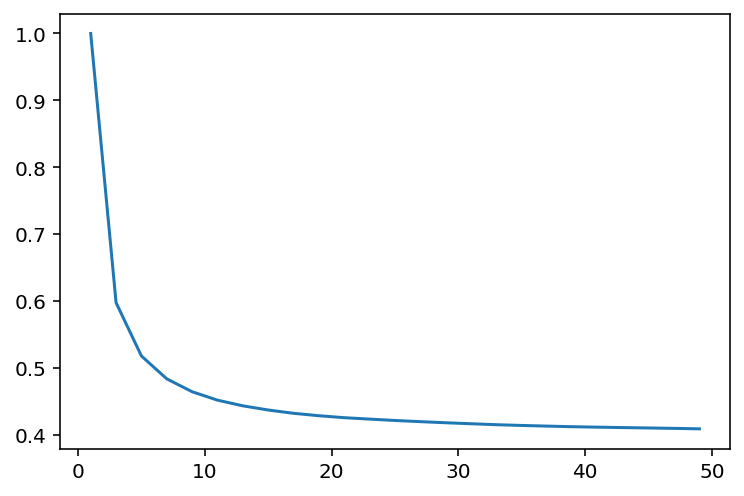

In [103]:
plt.plot(n_range, gs.cv_results_["mean_train_score"]);

Очевидно, что для&nbsp;$K=1$ на&nbsp;тренировочном наборе данных мы находим ровно ту же точку, что и нужно предсказать, и чем больше её соседей мы берём — тем меньше точность.

Картинка с тестового набора данных:

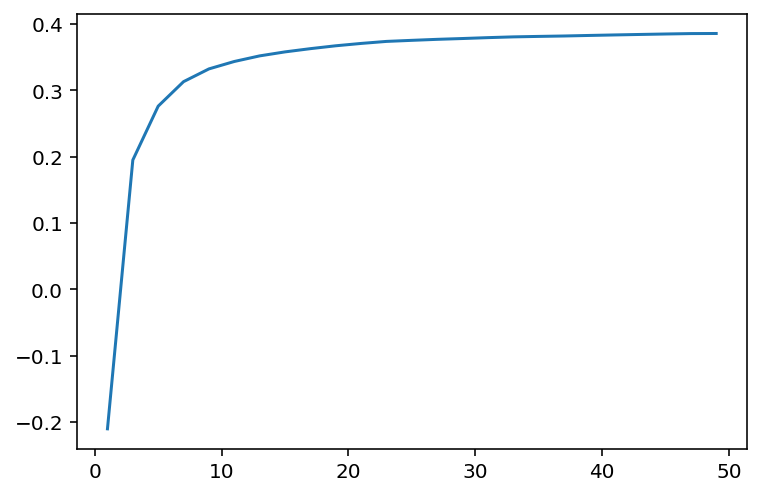

In [104]:
plt.plot(n_range, gs.cv_results_["mean_test_score"]);

Судя по полученным результатам, выбранный датасет не сликшом подходит для данного задания. Т.к. рещультат не превышает 0,4

Проверим получившуюся модель:

In [120]:
reg = KNeighborsRegressor(**gs.best_params_)
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 0.5172234693877551
median_absolute_error: 0.4285714285714288
r2_score: 0.3824127307424263


В&nbsp;целом получили примерно тот же результат. Очевидно, что проблема в&nbsp;том, что данный метод и так показал достаточно хороший результат для&nbsp;данной выборки.

Построим кривую обучения<cite data-cite="doc:sklearn"></cite>:

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None):
    train_sizes=np.linspace(.1, 1.0, 5)

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

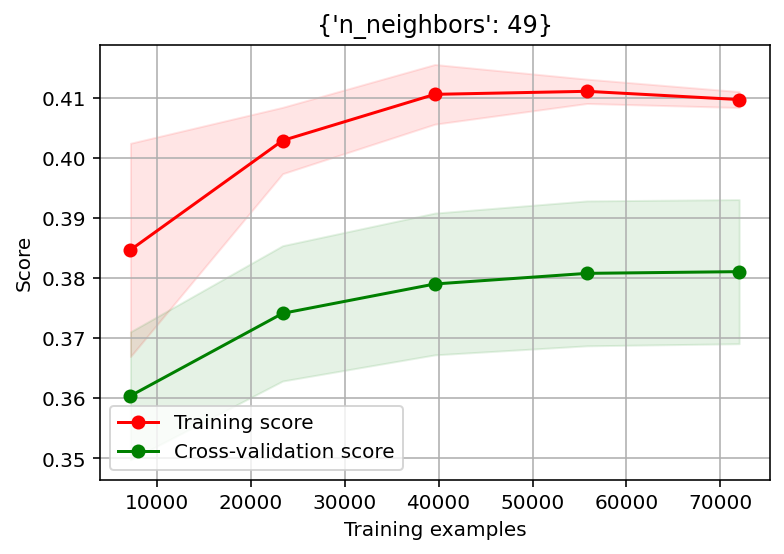

In [122]:
plot_learning_curve(reg, str(gs.best_params_), X, y,
                    cv=ShuffleSplit(n_splits=10));

Построим кривую валидации:

In [0]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name,
        param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean,
                 label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

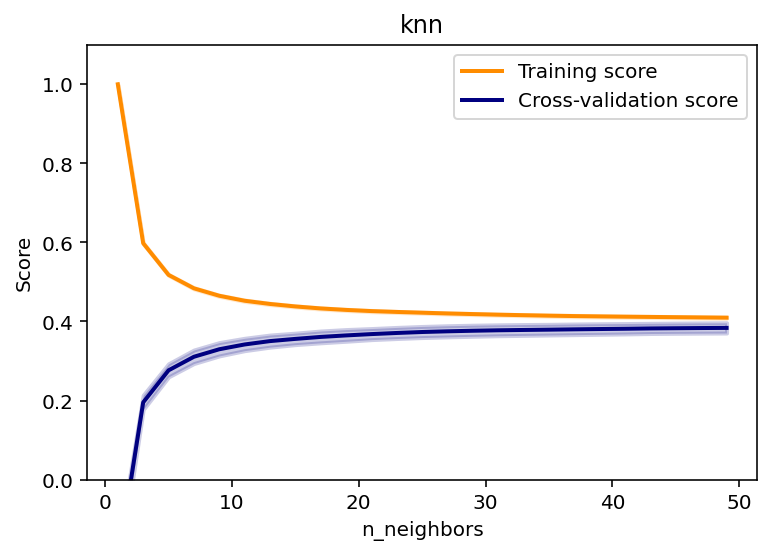

In [124]:
plot_validation_curve(KNeighborsRegressor(), "knn", X, y, 
                      param_name="n_neighbors", param_range=n_range, 
                      cv=ShuffleSplit(n_splits=10), scoring="r2");